# Import Modules

In [26]:
import sys
import os
import pandas as pd
import tqdm as tqdm
import xgboost as xgb
import numpy as np
import optuna
from pathlib import Path

# Import your custom modules. Adjust the module paths as needed.
from src.data.load_data import loadTrainingData
from sklearn.model_selection import train_test_split
from src.features.create_feature_vectors import extract_features_with_expanding_window
from src.plots.feature_plots import plot_roc_auc, plot_confusion_matrix
from sklearn.metrics import classification_report,fbeta_score,confusion_matrix
from sklearn import set_config

set_config(display="text")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', None)


In [27]:
def find_project_root(marker=".gitignore"):
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}")
    
root = find_project_root()

# Load Data

In [28]:
directories = [f'{root}/training_setA/', f'{root}/training_setB/']
max_files = 5000  # Adjust as needed

patient_dict = {}

for directory in directories:
    pattern = os.path.join(directory, "*.psv")
    print(f"\nLoading data from: {pattern} with max_files={max_files}")
    patient_data = loadTrainingData(
        pattern,
        max_files,
        ignore_columns=['Unit2','Unit1','ICULOS','HospAdmTime']
    )
    patient_dict.update(patient_data)


Loading data from: /Users/lukeedwards/Desktop/sepsis/training_setA/*.psv with max_files=5000
























Extracting features with expanding window:  21%|██        | 8399/40336 [03:55<14:57, 35.59it/s] 








































































Loading PSV Files: 100%|██████████| 5000/5000 [00:06<00:00, 771.67it/s] 



Loading data from: /Users/lukeedwards/Desktop/sepsis/training_setB/*.psv with max_files=5000


Loading PSV Files: 100%|██████████| 5000/5000 [00:05<00:00, 888.30it/s] 


# Create Feature Vectors

In [29]:
feature_df = extract_features_with_expanding_window(patient_dict)

Extracting features with expanding window: 100%|██████████| 10000/10000 [01:41<00:00, 98.99it/s] 
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.7min finished


Final shape of expanded feature DataFrame: (383239, 109)


 # Save or Load Feature

In [30]:
def save_feature_data(feature_df, file_path="feature_data.pkl"):
    feature_df.to_pickle(file_path)
    print(f"Feature data saved to {file_path}")

def load_feature_data(file_path="feature_data.pkl"):
    feature_df = pd.read_pickle(file_path)
    print(f"Feature data loaded from {file_path}")
    return feature_df

# feature_df = load_feature_data()
# save_feature_data(feature_df)

# Add/Remove features

In [31]:
feature_df.columns

Index(['HR_5_mean', 'HR_5_min', 'HR_5_max', 'HR_5_median', 'HR_5_var',
       'HR_5_q95', 'HR_5_q05', 'HR_5_energy', 'HR_5_slope', 'O2Sat_5_mean',
       'O2Sat_5_min', 'O2Sat_5_max', 'O2Sat_5_median', 'O2Sat_5_var',
       'O2Sat_5_q95', 'O2Sat_5_q05', 'O2Sat_5_energy', 'O2Sat_5_slope',
       'Temp_5_mean', 'Temp_5_min', 'Temp_5_max', 'Temp_5_median',
       'Temp_5_var', 'Temp_5_q95', 'Temp_5_q05', 'Temp_5_energy',
       'Temp_5_slope', 'SBP_5_mean', 'SBP_5_min', 'SBP_5_max', 'SBP_5_median',
       'SBP_5_var', 'SBP_5_q95', 'SBP_5_q05', 'SBP_5_energy', 'SBP_5_slope',
       'MAP_5_mean', 'MAP_5_min', 'MAP_5_max', 'MAP_5_median', 'MAP_5_var',
       'MAP_5_q95', 'MAP_5_q05', 'MAP_5_energy', 'MAP_5_slope', 'DBP_5_mean',
       'DBP_5_min', 'DBP_5_max', 'DBP_5_median', 'DBP_5_var', 'DBP_5_q95',
       'DBP_5_q05', 'DBP_5_energy', 'DBP_5_slope', 'Resp_5_mean', 'Resp_5_min',
       'Resp_5_max', 'Resp_5_median', 'Resp_5_var', 'Resp_5_q95', 'Resp_5_q05',
       'Resp_5_energy', 'Resp_5_s

In [32]:
feature_df.shape

(383239, 109)

# Split Sets into Test and Train on Patient ID of Dictionary

In [33]:
# Group rows by patient_id to create a patient-wise dictionary.
patient_groups = {patient_id: group 
                  for patient_id, group in feature_df.groupby("patient_id")}

# Create a new dictionary with keys indicating sepsis status.
# For each patient, if any row's SepsisLabel equals 1, mark that patient as sepsis.
labeled_patients = {}
for patient_id, df in patient_groups.items():
    # Check if the patient ever had sepsis
    sepsis_label = "1" if df["SepsisLabel"].any() else "0"
    new_key = f"{patient_id}_{sepsis_label}"
    labeled_patients[new_key] = df

# Optional: Print counts to verify split counts
sepsis_count = sum(1 for key in labeled_patients if key.endswith('_1'))
nonsepsis_count = sum(1 for key in labeled_patients if key.endswith('_0'))
print(f"Number of SEPSIS patients: {sepsis_count}")
print(f"Number of NON-SEPSIS patients: {nonsepsis_count}")

# Now, create a list of keys and a matching list of binary labels for stratification.
keys = list(labeled_patients.keys())
labels = [1 if key.endswith('_sepsis') else 0 for key in keys]  # 1 = sepsis, 0 = no sepsis

# Split the keys into train and test sets while maintaining the sepsis proportion.
train_keys, test_keys, _, _ = train_test_split(
    keys, labels, test_size=0.2, random_state=42, stratify=labels
)

# Build train and test dictionaries from the split keys.
train_data_dict = {key: labeled_patients[key] for key in train_keys}
test_data_dict = {key: labeled_patients[key] for key in test_keys}

# Optional: Verify the stratification in your splits.
train_sepsis = sum(1 for key in train_data_dict if key.endswith('_1'))
test_sepsis = sum(1 for key in test_data_dict if key.endswith('_1'))
print(f"Train SEPSIS: {train_sepsis}, NON-SEPSIS: {len(train_data_dict) - train_sepsis}")
print(f"Test SEPSIS: {test_sepsis}, NON-SEPSIS: {len(test_data_dict) - test_sepsis}")

# If needed, you can also concatenate these dictionaries back into DataFrames:
train_df = pd.concat(train_data_dict.values(), ignore_index=True)
test_df = pd.concat(test_data_dict.values(), ignore_index=True)

train_df = train_df.drop(columns=['patient_id'])
test_df = test_df.drop(columns=['patient_id'])

Number of SEPSIS patients: 693
Number of NON-SEPSIS patients: 9307
Train SEPSIS: 568, NON-SEPSIS: 7432
Test SEPSIS: 125, NON-SEPSIS: 1875


#  Train Model

In [34]:
# Separate features and target
X_train = train_df.drop(columns=["SepsisLabel"], errors="ignore")
y_train = train_df["SepsisLabel"]

X_test = test_df.drop(columns=["SepsisLabel"], errors="ignore")
y_test = test_df["SepsisLabel"]

neg_samples, pos_samples = y_train.value_counts()
neg_samples_test, pos_samples_test = y_test.value_counts()
print(f"Negative samples of Train: {neg_samples}, Positive samples of Train: {pos_samples}")
print(f"Negative samples of Test: {neg_samples_test}, Positive samples of Test: {pos_samples_test}")

Negative samples of Train: 301368, Positive samples of Train: 5395
Negative samples of Test: 75288, Positive samples of Test: 1188


# Optuna HyperParams

In [35]:
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import StratifiedKFold, cross_val_score
# from optuna.terminator import report_cross_validation_scores
# from optuna.visualization import plot_terminator_improvement
# from plotly.io import show

# def objective(trial):
#     # Define a search space for hyperparameters.
#     params = {
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1e1),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'objective': 'binary:logistic',
#         'eval_metric': 'auc',
#         'scale_pos_weight': neg_samples / pos_samples,
#         'random_state': 42,
#         'use_label_encoder': False
#     }
    
#     # Use stratified 3-fold cross-validation.
#     skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#     clf = xgb.XGBClassifier(**params)
    
#     # Define a scoring function based on F_beta score with beta=4.5.
#     scorer = make_scorer(fbeta_score, beta=4.5)
#     scores = cross_val_score(clf, X_train, y_train, scoring=scorer, cv=skf)
    
#     # Return the mean F_beta score.
#     return np.mean(scores)

# # Create an Optuna study object to maximize the F_beta score.
# study = optuna.create_study(direction='maximize')
# print("Starting hyperparameter tuning with Optuna...")
# study.optimize(objective, n_trials=15)

# fig = plot_terminator_improvement(study, plot_error=True)
# show(fig)

# # Output the best trial.
# print("Best trial:")
# print("  F_beta Score: ", study.best_trial.value)
# print("  Params: ", study.best_trial.params)

# # Extract best parameters and add fixed parameters.
# best_params = study.best_trial.params
# best_params['objective'] = 'binary:logistic'
# best_params['eval_metric'] = 'auc'
# best_params['scale_pos_weight'] = neg_samples / pos_samples
# best_params['random_state'] = 42
# best_params['use_label_encoder'] = False

In [36]:
# Cell 5: Train model
model = xgb.XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    eval_metric="auc",
    scale_pos_weight=neg_samples / pos_samples
)
model.fit(X_train, y_train, 
          eval_set=[(X_test, y_test)],
          verbose=1)

[0]	validation_0-auc:0.63106
[1]	validation_0-auc:0.65647
[2]	validation_0-auc:0.68268
[3]	validation_0-auc:0.69428
[4]	validation_0-auc:0.69675
[5]	validation_0-auc:0.69555
[6]	validation_0-auc:0.70587
[7]	validation_0-auc:0.70916
[8]	validation_0-auc:0.70855
[9]	validation_0-auc:0.70962
[10]	validation_0-auc:0.70770
[11]	validation_0-auc:0.70931
[12]	validation_0-auc:0.70715
[13]	validation_0-auc:0.71025
[14]	validation_0-auc:0.71167
[15]	validation_0-auc:0.71339
[16]	validation_0-auc:0.70725
[17]	validation_0-auc:0.70639
[18]	validation_0-auc:0.69959
[19]	validation_0-auc:0.69912
[20]	validation_0-auc:0.69864
[21]	validation_0-auc:0.69725
[22]	validation_0-auc:0.69766
[23]	validation_0-auc:0.69590
[24]	validation_0-auc:0.69832
[25]	validation_0-auc:0.69531
[26]	validation_0-auc:0.69460
[27]	validation_0-auc:0.69343
[28]	validation_0-auc:0.69327
[29]	validation_0-auc:0.69070
[30]	validation_0-auc:0.68896
[31]	validation_0-auc:0.68931
[32]	validation_0-auc:0.68936
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

# Evaluate Model

Subset ROC AUC (predicted=1 or actual=1): 0.026


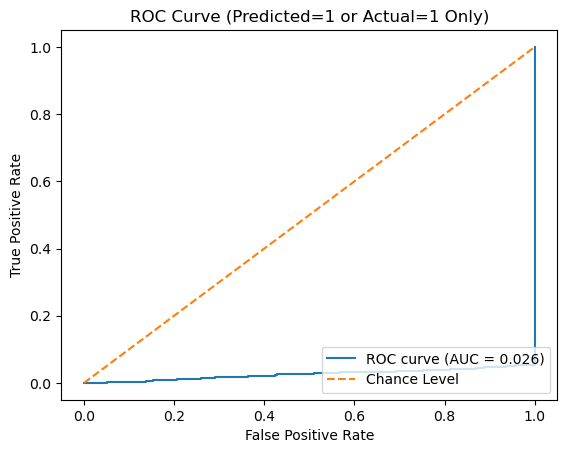

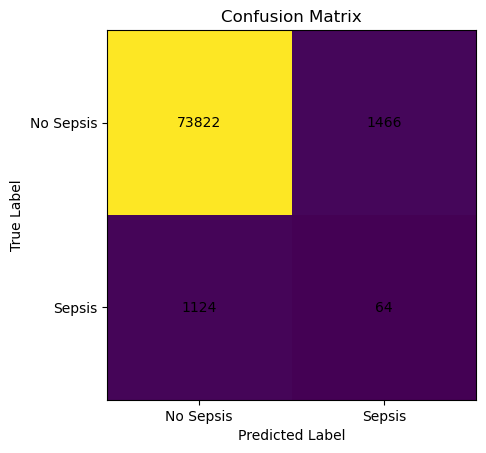


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     75288
         1.0       0.04      0.05      0.05      1188

    accuracy                           0.97     76476
   macro avg       0.51      0.52      0.51     76476
weighted avg       0.97      0.97      0.97     76476



In [37]:
from src.plots.feature_plots import plot_roc_auc, plot_confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

plot_roc_auc(model, X_test, y_test)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=("No Sepsis", "Sepsis"))

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Maximise Threshold

In [38]:
thresholds = np.arange(0.0, 1.0, 0.01)

f_beta_scores = []
beta_val = 4.5

for t in thresholds:
    y_pred_threshold = (y_proba >= t).astype(int)
    fb = fbeta_score(y_test, y_pred_threshold, beta=beta_val)
    f_beta_scores.append(fb)

optimal_threshold = thresholds[np.argmax(f_beta_scores)]
print(f"Optimal threshold: {optimal_threshold}, F Beta {beta_val} Score: {max(f_beta_scores)}")

Optimal threshold: 0.01, F Beta 4.5 Score: 0.2825684535287312


# Re-evaluate Model

Subset ROC AUC (predicted=1 or actual=1): 0.447


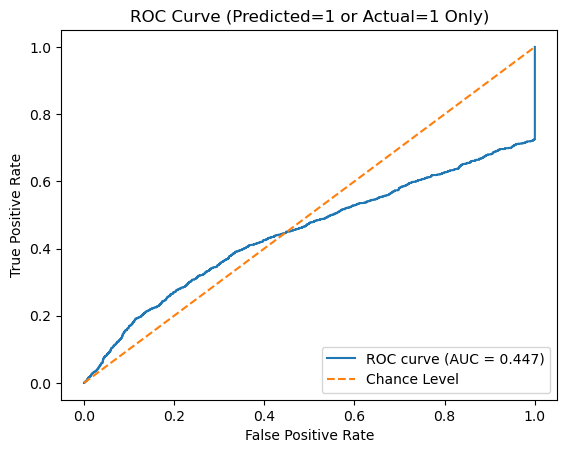

              precision    recall  f1-score   support

         0.0       0.99      0.47      0.64     75288
         1.0       0.02      0.73      0.04      1188

    accuracy                           0.47     76476
   macro avg       0.51      0.60      0.34     76476
weighted avg       0.98      0.47      0.63     76476

[[35382 39906]
 [  326   862]]


In [39]:
# Get predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Apply the threshold to get the new predictions
y_pred_custom = (y_proba >= optimal_threshold).astype(int)


plot_roc_auc(model, X_test, y_test, optimal_threshold)

print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))

# Feature Importance

In [40]:
feature_importances = model.feature_importances_
features = X_test.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
importance_df.head(100)

,Feature,Importance
73,FiO2,0.052788
65,Temp,0.028397
20,Temp_5_max,0.026060
33,SBP_5_q05,0.024173
96,Platelets,0.021271
70,EtCO2,0.019798
100,age_normalised_shock_index,0.019765
82,Creatinine,0.016783
77,AST,0.014615
23,Temp_5_q95,0.014416


# Shap Importance

# Utility Score

# Most Important Features